## Neural Machine Translation for the EN-RU pair of languages

### Environment setup

In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

!pip install torch --upgrade
!pip install torchtext --upgrade
!pip install pytorch-nlp
!pip install nltk
!pip install git+https://github.com/aatimofeev/spacy_russian_tokenizer.git
!pip install pymorphy2

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2021-02-28 12:58:03--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.1s    

2021-02-28 12:58:04 (89.2 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [3]:
import tqdm
import math
import time
import random
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
import torchnlp.nn as nlpnn

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

import spacy
from spacy.lang.ru import Russian
from spacy_russian_tokenizer import RussianTokenizer, MERGE_PATTERNS

In [4]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [5]:
en_tok = spacy.load('en')

def tokenize_en(sentence):
    return [tok.text for tok in en_tok.tokenizer(sentence)]

# tokenizer_W = WordPunctTokenizer()
# def tokenize(x, tokenizer=tokenizer_W):
#     return tokenizer.tokenize(x.lower())

In [6]:
ru_nlp = Russian()
russian_tokenizer = RussianTokenizer(ru_nlp, MERGE_PATTERNS)
ru_nlp.add_pipe(russian_tokenizer, name='russian_tokenizer')

def tokenize_ru(sentence):
    return [tok.text for tok in ru_nlp(sentence)]

In [7]:
SRC = Field(tokenize=tokenize_en,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize_ru,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('src', SRC), ('trg', TRG)]
)

In [8]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [9]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [10]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [11]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 6823
Unique tokens in target (en) vocabulary: 9341


Here are tokens from original (EN) corpus:

In [12]:
SRC.vocab.itos[::1000]

['<unk>', 'spot', 'snow', 'trastevere', 'horizon', 'plate', 'juliet']

And from target (RU) corpus:

In [13]:
TRG.vocab.itos[::1000]

['<unk>',
 'такими',
 'ан',
 'лесной',
 'частности',
 'центральным',
 'giardini',
 'тайский',
 'горячем',
 'солнечным']

And here is example from train dataset:

In [14]:
print(vars(train_data.examples[9]))

{'src': ['some', 'units', 'include', 'a', 'seating', 'or', 'dining', 'area', ',', 'and', 'most', 'of', 'them', 'offer', 'views', 'over', 'the', 'aegean', 'sea', 'or', 'the', 'garden', '.'], 'trg': ['в', 'некоторых', 'люксах', 'имеется', 'обеденная', 'или', 'гостиная', 'зона', '.', 'из', 'окон', 'большинства', 'номеров', 'открывается', 'вид', 'на', 'эгейское', 'море', 'или', 'сад', '.']}


Let's check the length distributions:

Length distribution in Train data


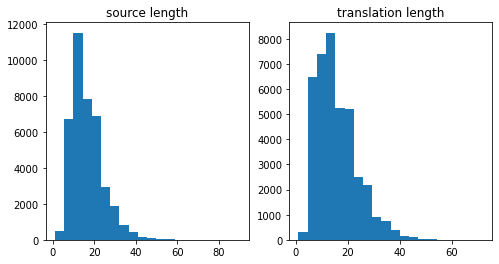

In [15]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


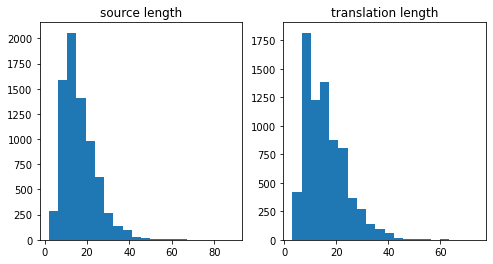

In [16]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

There are quite a lot of sentences with more than 20 words. After this point the quality of translations decreases unless the attention is used. That is why the attention might result in big profit.

### Model side
Improved the baseline (plain encoder-decoder) model by applying the following things:
- ReduceLROnPlateau(factor=0.3, patience=3)
- batch_size=64 (the less batch_size, the higher BLEU, compared with 128 and 256)
- Attention(attention_type='dot'). Used Pytorch NLP library with a IBM implementation of Attention. Quite simple (no multiplicative/additive approaches with additional weight matrices, just enough implementation)

Quite a basic approach but gives a great BLEU result.

Also, tried to combine CNN (2-layers + 2 ReLUs + 1 BatchNorm) with Encoder's LSTM. However, the result was worse than with the above-written model configs.

You may see the results table at the end of the notebook.

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [19]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )

        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )

        self.dropout = nn.Dropout(p=dropout)

    def _forward(self, src, h):
        src = src.unsqueeze(0)
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        output, (hidden, cell) = self.rnn(embedded, h)
        return hidden, cell

    def forward(self, src):
        # process word by word because we need to get all hidden states
        src_max_len = src.shape[0]
        input = src[0, :]
        enc_hiddens = None
        h = None
        for t in range(1, src_max_len):
            if t != 1:
                h = (hidden, cell)
            hidden, cell = self._forward(input, h)
            if enc_hiddens is None:
                enc_hiddens = hidden[0].unsqueeze(0)
            else:
                enc_hiddens = torch.cat((enc_hiddens, hidden[0].unsqueeze(0)), dim=0)
            input = src[t]
        return hidden, cell, enc_hiddens


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )

        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )

        self.attention = nlpnn.Attention(
            dimensions=hid_dim,
            attention_type='dot'
        )

        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input, hidden, cell, encoder_hiddens):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # need some permutations
        output, weights = self.attention(hidden[0].unsqueeze(0).permute((1, 0, 2)), encoder_hiddens.permute((1, 0, 2)))
        output = output.permute((1, 0, 2)).squeeze(0)
        prediction = self.out(output)
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        # process encoding and get all hidden states
        hidden, cell, enc_hiddens = self.encoder(src)

        # decoding
        input = trg[0, :]
        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input, hidden, cell, enc_hiddens)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)

        return outputs

In [20]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [21]:
def init_weights(m):
    """ Initializes weights uniformly """
    
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6823, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(9341, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention(
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=512, out_features=9341, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [22]:
def count_parameters(model):
    """ Count number of trainable parameters in the model """
    
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 16,810,621 trainable parameters


In [34]:
# Define optimizer, scheduler and loss function

PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=4)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [35]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    """ Implements main training loop """
    
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [36]:
def evaluate(model, iterator, criterion):
    """ Evaluates the model on the given dataset """
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [37]:
def epoch_time(start_time, end_time):
    """ Calculates the elapsed time for one epoch in minutes and seconds """
    
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [38]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

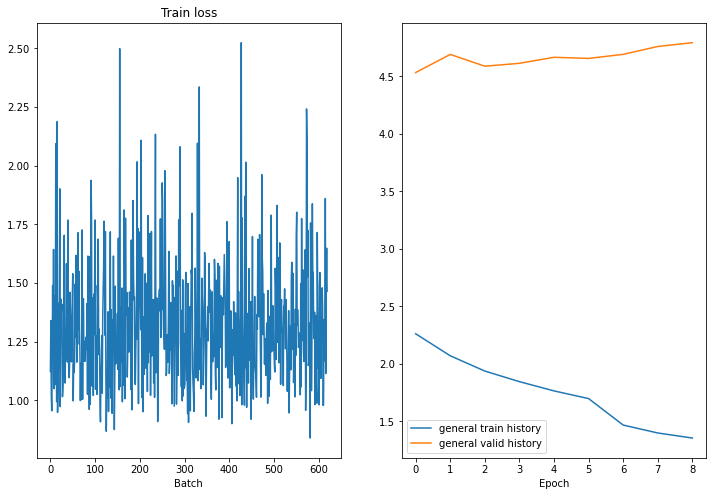

Epoch: 10 | Time: 2m 59s
	Train Loss: 1.321 | Train PPL:   3.749
	 Val. Loss: 4.858 |  Val. PPL: 128.748


In [39]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)

    scheduler.step(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [40]:
def flatten(l):
    return [item for sublist in l for item in sublist]


def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    """ Converts word indexes to strings in the vocabulary """
    
    text = [TRG_vocab.itos[token] for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text


def generate_translation(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg, 0)  # turn off teacher forcing
    output = output.argmax(dim=-1).cpu().numpy()

    original = get_text(list(trg[:, 0].cpu().numpy()), TRG_vocab)
    generated = get_text(list(output[1:, 0]), TRG_vocab)

    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

In [41]:
batch = next(iter(test_iterator))

In [42]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: гости смогут принять участие в пеших в сопровождении гида .
Generated: владелец организует пешие походы . гидом .

Original: к услугам гостей бесплатный wifi .
Generated: предоставляется бесплатный wi-fi .



In [43]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

118it [00:06, 18.10it/s]


In [44]:
# Calculate blue score

print(f'Bleu score: {corpus_bleu([[text] for text in original_text], generated_text) * 100}')

Bleu score: 31.79685533865809


### Results Table

|                                                     Model updates <br>(compared to baseline model)                                                     | Complexity <br>(# of training parameters) | Training time<br>per an epoch* | Quality<br>(in BLEU) | Comments                                                                                                                                                                                              |
|:------------------------------------------------------------------------------------------------------------------------------------------------------:|:-----------------------------------------:|:------------------------------:|:--------------------:|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|                                               ReduceLROnPlateau(factor=0.3, patience=5),<br> <br>epoch=20                                              |                 14,911,318                |          1 min 24 sec          |         17.97        | This may be because of the <br><br>increase of # of epochs                                                                                                                                      |
|                                   ReduceLROnPlateau(factor=0.3, patience=4),<br><br>epoch=10,<br><br>Attention('dot')                                  |                 15,378,701                |          1 min 47 sec          |         28.37        | Decreased patience in the scheduler to react faster.<br><br>Attention gives a great improvement of BLEU.                                                                                              |
|                       ReduceLROnPlateau(factor=0.3, patience=3),<br><br>epoch=10,<br> <br>batch_size=64,<br> <br>Attention('dot')                      |                 15,378,701                |            2 min 30s           |         31.79        | The batch size has an impact on quality. <br><br>batch_size=256 worsened the BLEU so making opposite<br><br>action (decreasing to 64) we found out that it improves the result.         |


* The time may differ from real values because we used Google Colab and it sometimes gives a slow machine.